# Checking quality of the reads - Working with FASTQ files

Here, we will work with FASTQ files, the standard format output used by modern sequencers. You will learn how to work with quality scores per base.

### Data
```
@SRR003258.1 30443AAXX:1:1:1053:1999 length=51 
ACCCCCCCCCACCCCCCCCCCCCCCCCCCCCCCCCCCACACACACCAACAC
+
=IIIIIIIII5IIIIIII>IIII+GIIIIIIIIIIIIII(IIIII01&III```

Line 1 starts with @, followed by a sequence identifier and a description string. The description string will vary from a sequencer or a database source, but will normally be amenable to automated parsing.
The second line has the sequence DNA, which is just like a FASTA file. The third line is a +, sometimes followed by the description line on the first line.
The fourth line contains quality values for each base that's read on line two. Each letter encodes a Phred quality score, which assigns a probability of error to each read.

### Reading FASTQ files

In [1]:
!pip install biopython
!pip install seaborn
!pip install matplotlib

from collections import defaultdict
import gzip

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from Bio import SeqIO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.2 MB/s eta 0:00:0000:0100:01


In [2]:
recs = SeqIO.parse(gzip.open('RawData/CBX2_KO_1_1.fq.gz', 'rt', encoding='utf-8'), 'fastq')
rec = next(recs)
print(rec)
print(rec.id, rec.description, rec.seq)
print(rec.letter_annotations) # quality scores of our reads, per letter

ID: A00564:762:HCLL7DSX7:1:1101:1542:1000
Name: A00564:762:HCLL7DSX7:1:1101:1542:1000
Description: A00564:762:HCLL7DSX7:1:1101:1542:1000 1:N:0:CTTGTGCTAC+NTCTGTCTAC
Number of features: 0
Per letter annotation for: phred_quality
Seq('NGAACGTGGTCGACATGACCCGTCAAGGTCTATTTGACCTCTTAAAAGTATAGC...TCG')
A00564:762:HCLL7DSX7:1:1101:1542:1000 A00564:762:HCLL7DSX7:1:1101:1542:1000 1:N:0:CTTGTGCTAC+NTCTGTCTAC NGAACGTGGTCGACATGACCCGTCAAGGTCTATTTGACCTCTTAAAAGTATAGCCAGCCAGCCACCCCACGTGCCTATGATTTAGCAATGACACCTCTGATGGCATCCGCGCCATCCAGAGCCTGGATTAGTGTGGTGTGTCTCAGATCG
{'phred_quality': [2, 37, 37, 37, 37, 37, 37, 37, 25, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 11, 37, 37, 37, 37, 11, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 11, 25, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 25, 25, 37, 37, 37, 37, 37, 37, 37, 37, 25, 37, 37, 37, 25, 37, 37, 37, 11, 37,

### PHRED QUALITY SCORES
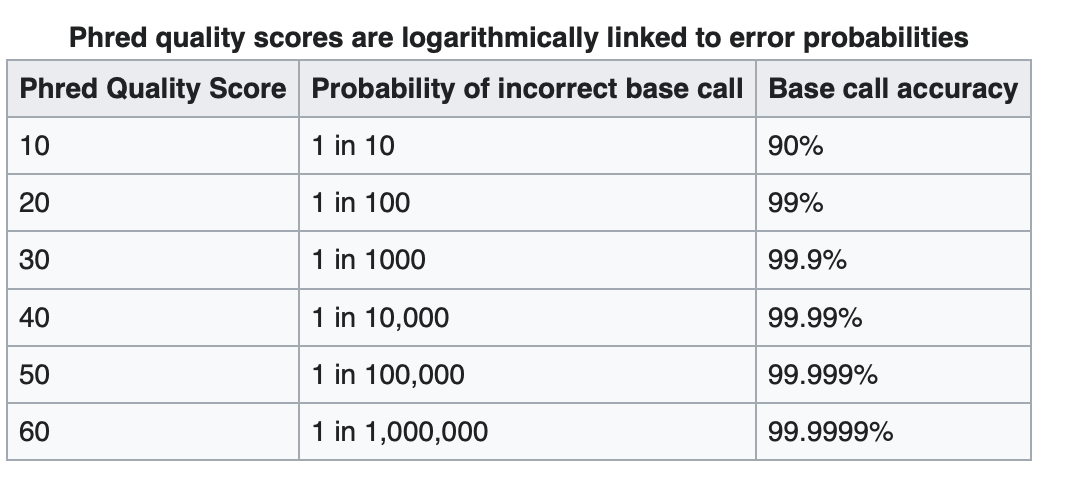

### Distribution of nucleotide reads

In [5]:
recs = SeqIO.parse(gzip.open('RawData/CBX2_KO_1_1.fq.gz', 'rt', encoding='utf-8'), 'fastq')
count = defaultdict(int)
for rec in recs:
    for letter in rec.seq:
        count[letter] += 1
tot = sum(count.values())
for letter, count in count.items():
    print('%s: %.2f %d' % (letter, 100. * count / tot, count))

N: 0.00 26651
G: 25.03 817148398
A: 24.98 815257848
C: 25.20 822417275
T: 24.79 809277478


N - uncalled base

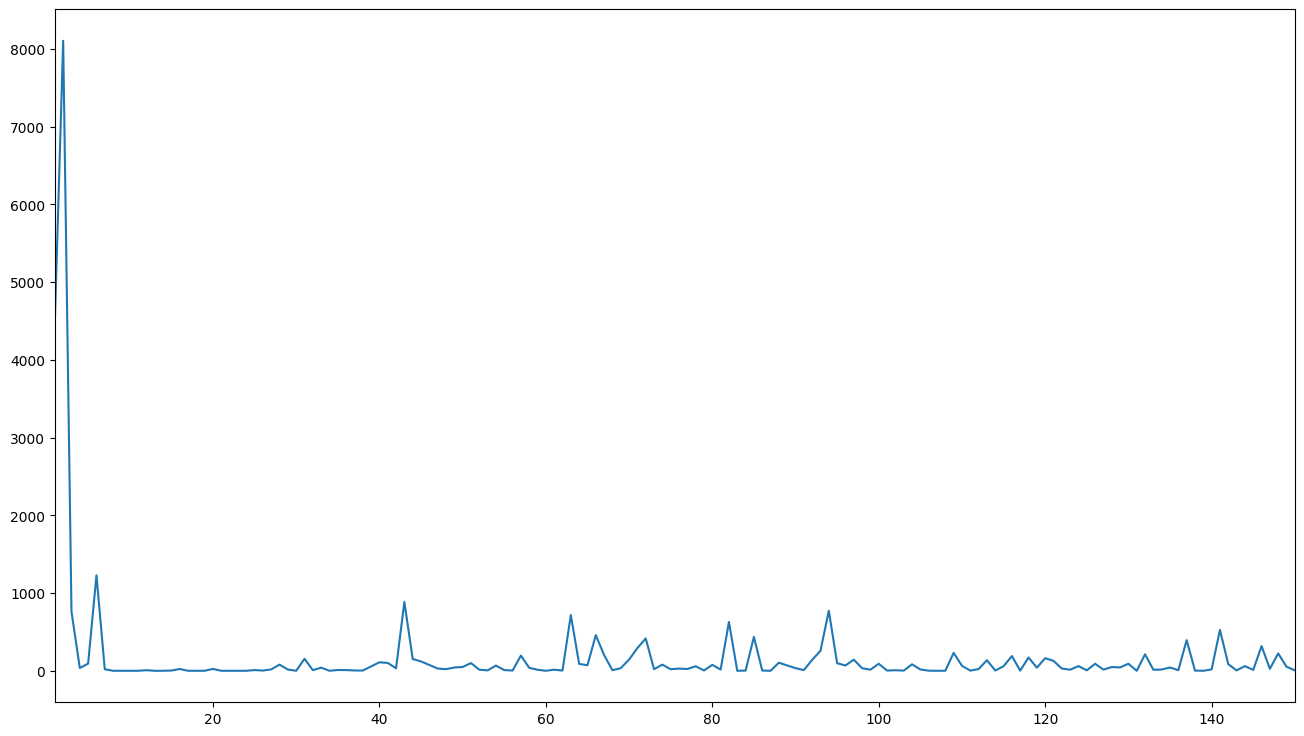

In [6]:
recs = SeqIO.parse(gzip.open('RawData/CBX2_KO_1_1.fq.gz', 'rt', encoding='UTF-8'), 'fastq')
n_cnt = defaultdict(int)
for rec in recs:
    for i, letter in enumerate(rec.seq):
        pos = i + 1
        if letter == 'N':
            n_cnt[pos] += 1
seq_len = max(n_cnt.keys())
positions = range(1, seq_len + 1)
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(positions, [n_cnt[x] for x in positions])
ax.set_xlim(1, seq_len)
pass

In [38]:
read1 = 'RawData/CBX2_KO_1_1.fastq.gz'
read2 = 'RawData/CBX2_KO_1_2.fastq.gz'
!trim_galore --cores 32 --trim-n --max_n 15 --paired $read1 $read2 -o test/

Using an excessive number of cores has a diminishing return! It is recommended not to exceed 8 cores per trimming process (you asked for 32 cores). Please consider re-specifying
Path to Cutadapt set as: 'cutadapt' (default)
Cutadapt seems to be working fine (tested command 'cutadapt --version')
Cutadapt version: 4.2
Cutadapt seems to be using Python 3! Proceeding with multi-core enabled Cutadapt using 32 cores
pigz 2.6
Parallel gzip (pigz) detected. Proceeding with multicore (de)compression using 32 cores

Proceeding with 'pigz -p 4' for decompression
To decrease CPU usage of decompression, please install 'igzip' and run again

No quality encoding type selected. Assuming that the data provided uses Sanger encoded Phred scores (default)

Output will be written into the directory: /home/davoudis/epigenetics/test/


AUTO-DETECTING ADAPTER TYPE
Attempting to auto-detect adapter type from the first 1 million sequences of the first file (>> RawData/CBX2_KO_1_1.fastq.gz <<)

Found perfect mat

### Statistics of the reads

In [4]:
import os
import gzip
import argparse
import pandas as pd
from Bio import SeqIO

# Define a function to calculate the size in GB
def bytes_to_gb(byte_count):
    return byte_count / (1000 ** 3)

# Calculate the GC content percentage for a sequence
def calculate_gc_content(sequence):
    gc_count = sequence.count('G') + sequence.count('C')
    return gc_count

# Create a function to process a pair of samples
def process_sample_pair(sample_path_1, sample_path_2):
    sample_name = os.path.basename(sample_path_1).replace('_1.fastq.gz', '')
    raw_read_count = 0
    raw_base_count = 0
    clean_read_count = 0
    clean_base_count = 0
    phred_20_count = 0
    phred_30_count = 0
    gc_percentage = 0  # Initialize GC percentage
    clean_reads = []

    for sample_path in [sample_path_1, sample_path_2]:
        with gzip.open(sample_path, 'rt') as fastq_file:
            for record in SeqIO.parse(fastq_file, 'fastq'):
                raw_read_count += 1
                raw_base_count += len(record.seq)
    
    sample_path_1 = os.path.join('QC-result/', sample_name + '_1_val_1.fq.gz')
    sample_path_2 = os.path.join('QC-result/', sample_name + '_2_val_2.fq.gz')
    
    for sample_path in [sample_path_1, sample_path_2]:
        with gzip.open(sample_path, 'rt') as fastq_file:
            for record in SeqIO.parse(fastq_file, 'fastq'):
                clean_read_count += 1
                clean_base_count += len(record.seq)
                clean_reads.append(record)

                # Calculate Phred scores
                phred_20_count += sum(1 for q in record.letter_annotations["phred_quality"] if q > 20)
                phred_30_count += sum(1 for q in record.letter_annotations["phred_quality"] if q > 30)

                # Calculate GC content percentage
                gc_percentage += calculate_gc_content(record.seq)

    # Calculate error rate
    error_rate = 1 - (clean_read_count / raw_read_count)

    # Calculate percentages
    phred_20_percent = (phred_20_count / clean_base_count) * 100
    phred_30_percent = (phred_30_count / clean_base_count) * 100
    gc_percentage = (gc_percentage / (clean_base_count + 1)) * 100  # +1 to avoid division by zero

    # Create a dictionary to store the results
    result_dict = [sample_name, raw_read_count,
        bytes_to_gb(raw_base_count),
        clean_read_count,
        bytes_to_gb(clean_base_count),
        error_rate,
        phred_20_percent,
        phred_30_percent,
        gc_percentage
    ]

    return result_dict

In [ ]:
# parser = argparse.ArgumentParser(description="Process FASTQ files and append summary statistics to a CSV file.")
# parser.add_argument("input_dir", help="Input directory containing FASTQ files.")
# parser.add_argument("output_dir", help="Output directory for clean FASTQ files.")
# args = parser.parse_args()

input_dir = 'RawData/'
output_dir = 'QC-Results/'
sample_name_list = []
raw_read_count_list = []
raw_base_size_list = []
clean_read_count_list = []
clean_base_size_list = []
error_rate_list = []
phred_20_percent_list = []
phred_30_percent_list = []
gc_content_percent_list = []


# Get a list of _1.fastq.gz files in the input directory
sample_files_1 = [f for f in os.listdir(input_dir) if f.endswith('_1.fastq.gz')]

# Process each pair of samples and append the results to the DataFrame and CSV file
for sample_file_1 in sample_files_1:
    sample_file_1 = os.path.join(input_dir, sample_file_1)
    sample_name_prefix = sample_file_1.replace('_1.fastq.gz', '')
    sample_file_2 = os.path.join(f"{sample_name_prefix}_2.fastq.gz")
    sample_name = os.path.basename(sample_file_1).replace('_1.fastq.gz', '')
    result_dict = process_sample_pair(sample_file_1, sample_file_2)
    sample_name_list.append(result_dict[0])
    raw_read_count_list.append(result_dict[1])
    raw_base_size_list.append(result_dict[2])
    clean_read_count_list.append(result_dict[3])
    clean_base_size_list.append(result_dict[4])
    error_rate_list.append(result_dict[5])
    phred_20_percent_list.append(result_dict[6])
    phred_30_percent_list.append(result_dict[7])
    gc_content_percent_list.append(result_dict[8])

# Create an empty DataFrame to store the results
result_df = pd.DataFrame({
    "Sample Name": sample_name_list,
    "Raw Read Count": raw_read_count_list,
    "Raw Base Size (GB)": raw_base_size_list,
    "Clean Read Count": clean_read_count_list,
    "Clean Base Size (GB)": clean_base_size_list,
    "Error Rate": error_rate_list,
    "Phred > 20 (%)": phred_20_percent_list,
    "Phred > 30 (%)": phred_30_percent_list,
    "GC Content (%)": gc_content_percent_list
})

result_df.to_csv(os.path.join(output_dir, 'sample_results.csv'), index=False)


In [34]:
import csv

def file_to_csv(file_path, csv_file_path):
    # Initialize an empty list to hold dictionaries
    dict_list = []
    
    with open(file_path, 'r') as file:
        lines = file.readlines()

    for line in lines:
        # Remove newlines and leading/trailing whitespace
        line = line.strip()
        
        # Skip empty lines
        if not line:
            continue
        
        # Check if the line contains the dictionary
        if line.startswith('{'):
            # Manually parse the string to a dictionary
            dict_str = line[1:-1]  # Remove the opening and closing braces
            dict_items = dict_str.split(", ")
            sample_dict = {}
            for item in dict_items:
                key, value = item.split(": ")
                key = key.strip("'")
                if value == 'None':
                    value = None
                elif value.startswith("'") and value.endswith("'"):
                    value = value[1:-1]
                elif '.' in value:
                    value = float(value)
                else:
                    value = int(value)
                sample_dict[key] = value
            dict_list.append(sample_dict)
    
    # Write the dictionaries to a CSV file
    with open(csv_file_path, 'w', newline='') as csvfile:
        fieldnames = dict_list[0].keys()
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        writer.writeheader()
        
        for row in dict_list:
            writer.writerow(row)

# Example usage
# Assume "sample_data.txt" contains the text data
file_path = "QC-result/data_table.txt"
csv_file_path = "QC-result/data_table.csv"
file_to_csv(file_path, csv_file_path)

In [35]:
data_table = pd.read_csv('QC-result/data_table.csv')
data_table

,Sample Name,Raw Read Count,Raw Base Size (GB),Clean Read Count,Clean Base Size (GB),Error Rate,Phred > 20 (%),Phred > 30 (%),GC Content (%)
0,CBX2_KO_1,43521702,6.528255,43504118,6.479057,0.000404,98.238268,94.945838,50.289800
1,dKO_Con_2,45958108,6.893716,45941502,6.838145,0.000361,98.175705,94.802217,49.399856
2,CBX7_KO_6h_1,48631876,7.294781,48615950,7.249056,0.000327,98.283422,95.023307,50.413686
3,CBX7_EtOH_2,43252604,6.487891,43233532,6.444894,0.000441,98.254258,94.977037,50.013697
4,dKO_6h_1,50944528,7.641679,50926586,7.584512,0.000352,98.326259,95.159154,50.456693
5,CBX7_KO_2h_2,41775638,6.266346,41761972,6.222978,0.000327,98.419823,95.342490,50.779770
6,CBX2_DMSO_2,42535488,6.380323,42522072,6.325938,0.000315,98.379826,95.282429,50.313574
7,dKO_Con_1,47985936,7.197890,47971372,7.137491,0.000304,98.375053,95.314978,50.564400
8,dKO_2h_1,42354482,6.353172,42339210,6.308044,0.000361,98.261935,94.994964,50.456707
9,CBX7_EtOH_1,43032302,6.454845,43016596,6.401897,0.000365,98.251404,94.979905,50.314846


In [41]:
read1 = 'QC-result/CBX2_KO_1_1_val_1.fq.gz'
read2 = 'QC-result/CBX2_KO_1_2_val_2.fq.gz'
read3 = 'QC-result/CBX7_KO_6h_1_1_val_1.fq.gz'
read4 = 'QC-result/CBX7_KO_6h_1_2_val_2.fq.gz'

#!hisat2-build mm39.fa genome
!hisat2 -p 128 -x genome -1 $read1 -2 $read2 | samtools view -bSh >Align-result/mm39/CBX2_KO_1.bam
!hisat2 -p 128 -x genome -1 $read3 -2 $read4 | samtools view -bSh >Align-result/mm39/CBX7_KO_6h_1.bam
!samtools sort -o Align-result/mm39/CBX2_KO_1_sorted.bam Align-result/mm39/CBX2_KO_1.bam
!samtools index Align-result/mm39/CBX2_KO_1_sorted.bam
!samtools sort -o Align-result/mm39/CBX7_KO_6h_1_sorted.bam Align-result/mm39/CBX7_KO_6h_1.bam
!samtools index Align-result/mm39/CBX7_KO_6h_1_sorted.bam

21752059 reads; of these:
  21752059 (100.00%) were paired; of these:
    1476193 (6.79%) aligned concordantly 0 times
    18711989 (86.02%) aligned concordantly exactly 1 time
    1563877 (7.19%) aligned concordantly >1 times
    ----
    1476193 pairs aligned concordantly 0 times; of these:
      70362 (4.77%) aligned discordantly 1 time
    ----
    1405831 pairs aligned 0 times concordantly or discordantly; of these:
      2811662 mates make up the pairs; of these:
        1613994 (57.40%) aligned 0 times
        1032868 (36.74%) aligned exactly 1 time
        164800 (5.86%) aligned >1 times
96.29% overall alignment rate
24307975 reads; of these:
  24307975 (100.00%) were paired; of these:
    1832657 (7.54%) aligned concordantly 0 times
    20879788 (85.90%) aligned concordantly exactly 1 time
    1595530 (6.56%) aligned concordantly >1 times
    ----
    1832657 pairs aligned concordantly 0 times; of these:
      106917 (5.83%) aligned discordantly 1 time
    ----
    1725740 pai

In [44]:
!samtools view Align-result/mm39/CBX2_KO_1_sorted.bam | head -n 10

A00564:765:H75GHDSX7:1:2568:21242:27132	355	chr1	3101703	1	149M	=	3101776	223	CAAGAGAGAGAGAAAACGAAACCCCGTCCCTATTAAGGAGAATTTTCCTTCGCCTAGGACGTGTCACTCCCTGATTGGCTGCAGCCCATCGGCCGAGTTGACGTCACGAGGAAGGCAGAGCACATGGAGTGAAGAACCACCCTCGGCAC	FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF	AS:i:0	ZS:i:0	XN:i:0	XM:i:0	XO:i:0	XG:i:0	NM:i:0	MD:Z:149	YS:i:0	YT:Z:CP	NH:i:5
A00564:765:H75GHDSX7:1:2568:21242:27132	403	chr1	3101776	1	150M	=	3101703	-223	ATTGGCTGCAGCCCATCGGCCGAGTTGACGTCACGAGGAAGGCAGAGCACATGGAGTGAAGAACCACCCTCGGCACATGCGCAGATTATTTGTTTACCACTTAGAACACAGCTGTCAGCGCCATCTTGTAACGGCGAATGTGGGCGCGGC	FF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF	AS:i:0	ZS:i:0	XN:i:0	XM:i:0	XO:i:0	XG:i:0	NM:i:0	MD:Z:150	YS:i:0	YT:Z:CP	NH:i:5
A00564:762:HCLL7DSX7:1:1202:21160:32252	129	chr1	3124150	60	3S147M	chr3	93625271	

In [45]:
!samtools view Align-result/mm39/CBX2_KO_1.bam | head -n 10

A00564:762:HCLL7DSX7:1:1101:1542:1000	97	chr6	120865295	60	143M	=	120865294	-144	GAACGTGGTCGACATGACCCGTCAAGGTCTATTTGACCTCTTAAAAGTATAGCCAGCCAGCCACCCCACGTGCCTATGATTTAGCAATGACACCTCTGATGGCATCCGCGCCATCCAGAGCCTGGATTAGTGTGGTGTGTCTC	FFFFFFF:FFFFFFFFFFFFFFFFFFF,FFFF,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF,:FFFFFFFFFFFFFFFF::FFFFFFFF:FFF:FFF,FF:FFFFFFFF:F:FFFFFF,F:FFFF:FFFFFFFFF	AS:i:0	XN:i:0	XM:i:0	XO:i:0	XG:i:0	NM:i:0	MD:Z:143	YS:i:0	YT:Z:DP	NH:i:1
A00564:762:HCLL7DSX7:1:1101:1542:1000	145	chr6	120865294	60	144M	=	120865295	144	GGAACGTGGTCGACATGACCCGTCAAGGTCTATTTGACCTCTTAAAAGTATAGCCAGCCAGCCACCCCACGTGCCTATGATTTAGCAATGACACCTCTGATGGCATCCGCGCCATCCAGAGCCTGGATTAGTGTGGTGTGTCTC	FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:,FFFF:::FFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFF:FFFFF:FFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFF	AS:i:0	XN:i:0	XM:i:0	XO:i:0	XG:i:0	NM:i:0	MD:Z:144	YS:i:0	YT:Z:DP	NH:i:1
A00564:762:HCLL7DSX7:1:1101:23656:1000	83	chr8	71917951	60	147M	=	71917694	-222	GCAGCAGGCTCGCGGCCGCGCGCGCGGAAACGAG

In [10]:
!hisat2 -p 128 -x genome -1 QC-result/CBX7_KO_2h_1_1_val_1.fq.gz -2 QC-result/CBX7_KO_2h_1_2_val_2.fq.gz | samtools view -bSh >Align-result/CBX7_KO_2h_1.bam

22184741 reads; of these:
  22184741 (100.00%) were paired; of these:
    1528220 (6.89%) aligned concordantly 0 times
    19327052 (87.12%) aligned concordantly exactly 1 time
    1329469 (5.99%) aligned concordantly >1 times
    ----
    1528220 pairs aligned concordantly 0 times; of these:
      82670 (5.41%) aligned discordantly 1 time
    ----
    1445550 pairs aligned 0 times concordantly or discordantly; of these:
      2891100 mates make up the pairs; of these:
        1742171 (60.26%) aligned 0 times
        1022769 (35.38%) aligned exactly 1 time
        126160 (4.36%) aligned >1 times
96.07% overall alignment rate


In [11]:
!hisat2 -p 64 -x genome -1 QC-result/CBX7_KO_6h_1_1_val_1.fq.gz -2 QC-result/CBX7_KO_6h_1_2_val_2.fq.gz | samtools view -bSh >Align-result/CBX7_KO_6h_1.bam

24307975 reads; of these:
  24307975 (100.00%) were paired; of these:
    1858372 (7.65%) aligned concordantly 0 times
    20890774 (85.94%) aligned concordantly exactly 1 time
    1558829 (6.41%) aligned concordantly >1 times
    ----
    1858372 pairs aligned concordantly 0 times; of these:
      106642 (5.74%) aligned discordantly 1 time
    ----
    1751730 pairs aligned 0 times concordantly or discordantly; of these:
      3503460 mates make up the pairs; of these:
        2053238 (58.61%) aligned 0 times
        1267467 (36.18%) aligned exactly 1 time
        182755 (5.22%) aligned >1 times
95.78% overall alignment rate


In [12]:
!hisat2 -p 64 -x genome -1 QC-result/dKO_2h_1_1_val_1.fq.gz -2 QC-result/dKO_2h_1_2_val_2.fq.gz | samtools view -bSh >Align-result/dKO_2h_1.bam

21169605 reads; of these:
  21169605 (100.00%) were paired; of these:
    1534005 (7.25%) aligned concordantly 0 times
    18271460 (86.31%) aligned concordantly exactly 1 time
    1364140 (6.44%) aligned concordantly >1 times
    ----
    1534005 pairs aligned concordantly 0 times; of these:
      81090 (5.29%) aligned discordantly 1 time
    ----
    1452915 pairs aligned 0 times concordantly or discordantly; of these:
      2905830 mates make up the pairs; of these:
        1706255 (58.72%) aligned 0 times
        1053956 (36.27%) aligned exactly 1 time
        145619 (5.01%) aligned >1 times
95.97% overall alignment rate


In [14]:
!hisat2 -p 64 -x genome -1 QC-result/dKO_6h_1_1_val_1.fq.gz -2 QC-result/dKO_6h_1_2_val_2.fq.gz | samtools view -bSh >Align-result/dKO_6h_1.bam

25463293 reads; of these:
  25463293 (100.00%) were paired; of these:
    1655693 (6.50%) aligned concordantly 0 times
    22187089 (87.13%) aligned concordantly exactly 1 time
    1620511 (6.36%) aligned concordantly >1 times
    ----
    1655693 pairs aligned concordantly 0 times; of these:
      77970 (4.71%) aligned discordantly 1 time
    ----
    1577723 pairs aligned 0 times concordantly or discordantly; of these:
      3155446 mates make up the pairs; of these:
        1848054 (58.57%) aligned 0 times
        1153060 (36.54%) aligned exactly 1 time
        154332 (4.89%) aligned >1 times
96.37% overall alignment rate


In [15]:
!hisat2 -p 64 -x genome -1 QC-result/dKO_Con_1_1_val_1.fq.gz -2 QC-result/dKO_Con_1_2_val_2.fq.gz | samtools view -bSh >Align-result/dKO_Con_1.bam

23985686 reads; of these:
  23985686 (100.00%) were paired; of these:
    1533768 (6.39%) aligned concordantly 0 times
    20821739 (86.81%) aligned concordantly exactly 1 time
    1630179 (6.80%) aligned concordantly >1 times
    ----
    1533768 pairs aligned concordantly 0 times; of these:
      55826 (3.64%) aligned discordantly 1 time
    ----
    1477942 pairs aligned 0 times concordantly or discordantly; of these:
      2955884 mates make up the pairs; of these:
        1786698 (60.45%) aligned 0 times
        1026550 (34.73%) aligned exactly 1 time
        142636 (4.83%) aligned >1 times
96.28% overall alignment rate


In [30]:
!samtools sort -o Align-result/dKO_Con_2_sorted.bam Align-result/dKO_Con_2.bam

[bam_sort_core] merging from 26 files and 1 in-memory blocks...


In [1]:
!samtools view -c -F 256 Align-result/CBX2_DMSO_1_sorted.bam

47468418


In [5]:
!samtools flagstat Align-result/CBX2_DMSO_1_sorted.bam

53702376 + 0 in total (QC-passed reads + QC-failed reads)
6233958 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
51875256 + 0 mapped (96.60% : N/A)
47468418 + 0 paired in sequencing
23734209 + 0 read1
23734209 + 0 read2
44337298 + 0 properly paired (93.40% : N/A)
44702944 + 0 with itself and mate mapped
938354 + 0 singletons (1.98% : N/A)
269830 + 0 with mate mapped to a different chr
217129 + 0 with mate mapped to a different chr (mapQ>=5)


In [ ]:
import pysam
import os
import pandas as pd

file_name_list = []
total_reads_list = []
total_map_list = []
unique_map_list = []
multi_map_list = []
read1_map_list = []
read2_map_list = []
positive_map_list = []
negative_map_list = []
splice_map_list = []
unsplice_map_list = []
proper_map_list = []

# Replace 'your_file.bam' with the path to your BAM file
for file_name in os.listdir('Align-result/'):
    if file_name.endswith('sorted.bam'):
        input_bam = os.path.join('Align-result/', file_name)
        # Initialize counters for each metric
        total_reads = 0
        total_map = 0
        unique_map = 0
        multi_map = 0
        read1_map = 0
        read2_map = 0
        positive_map = 0
        negative_map = 0
        splice_map = 0
        unsplice_map = 0
        proper_map = 0

        # Create a generator to filter reads in memory
        def filtered_reads_generator():
            with pysam.AlignmentFile(input_bam, 'rb') as bam_file:
                for read in bam_file:
                    if read.flag & 256 == 0:  # Check the bitwise flag to exclude reads with flag 256
                        yield read

        # Iterate over the filtered reads using the generator
        for read in filtered_reads_generator():
            total_reads += 1
            total_map += 1 if not read.is_unmapped else 0
            try:
                nh_tag = read.get_tag("NH")  # Try to get the NH tag
                if nh_tag == 1:
                    unique_map += 1
                elif nh_tag > 1:
                    multi_map += 1
            except KeyError:
                # Handle the case where the NH tag is not present
                pass

            if read.is_read1:
                read1_map += 1
            if read.is_read2:
                read2_map += 1
            if not read.is_unmapped:
                if read.is_reverse:
                    negative_map += 1
                else:
                    positive_map += 1
                if "N" in read.cigarstring:
                    splice_map += 1
                else:
                    unsplice_map += 1
                if read.is_proper_pair:
                    proper_map += 1
        file_name = file_name.replace('_sorted.bam', '')
    
        # Append the results to the lists
        file_name_list.append(file_name)
        total_reads_list.append(total_reads)
        total_map_list.append(f"{total_map}({total_map / total_reads * 100:.2f}%)")
        unique_map_list.append(f"{unique_map}({unique_map / total_map * 100:.2f}%)")
        multi_map_list.append(f"{multi_map}({multi_map / total_map * 100:.2f}%)")
        read1_map_list.append(f"{read1_map}({read1_map / total_map * 100:.2f}%)")
        read2_map_list.append(f"{read2_map}({read2_map / total_map * 100:.2f}%)")
        positive_map_list.append(f"{positive_map}({positive_map / total_map * 100:.2f}%)")
        negative_map_list.append(f"{negative_map}({negative_map / total_map * 100:.2f}%)")
        splice_map_list.append(f"{splice_map}({splice_map / total_map * 100:.2f}%)")
        unsplice_map_list.append(f"{unsplice_map}({unsplice_map / total_map * 100:.2f}%)")
        proper_map_list.append(f"{proper_map}({proper_map / total_map * 100:.2f}%)")
        
        # Print the results
        print(file_name)
        print("Total Reads:", total_reads)
        print("Total Mapped Reads:", total_map, "{:0.20f}".format(total_map / total_reads * 100))
        print("Unique Mapped Reads:", unique_map, "{:0.20f}".format(unique_map / total_map * 100))
        print("Multi-Mapped Reads:", multi_map, "{:0.20f}".format(multi_map / total_map * 100))
        print("Read 1 Mapped:", read1_map, "{:0.20f}".format(read1_map / total_map * 100))
        print("Read 2 Mapped:", read2_map, "{:0.20f}".format(read2_map / total_map * 100))
        print("Positive Strand Mapped:", positive_map, "{:0.20f}".format(positive_map / total_map * 100))
        print("Negative Strand Mapped:", negative_map, "{:0.20f}".format(negative_map / total_map * 100))
        print("Splice Mapped Reads:", splice_map, "{:0.20f}".format(splice_map / total_map * 100))
        print("Unsplice Mapped Reads:", unsplice_map, "{:0.20f}".format(unsplice_map / total_map * 100))
        print("Properly Mapped Reads:", proper_map, "{:0.20f}".format(proper_map / total_map * 100))

# Create a DataFrame from the results
result_df = pd.DataFrame({
    "Sample Name": file_name_list,
    "Total Reads": total_reads_list,
    "Total Mapped Reads": total_map_list,
    "Unique Mapped Reads": unique_map_list,
    "Multi-Mapped Reads": multi_map_list,
    "Read 1 Mapped": read1_map_list,
    "Read 2 Mapped": read2_map_list,
    "Positive Strand Mapped": positive_map_list,
    "Negative Strand Mapped": negative_map_list,
    "Splice Mapped Reads": splice_map_list,
    "Unsplice Mapped Reads": unsplice_map_list,
    "Properly Mapped Reads": proper_map_list
})

# Save the DataFrame to a CSV file
result_df.to_csv('Align-result/mapping_results.csv', index=False)


In [7]:
result_df

,Sample Name,Total Reads,Total Mapped Reads,Unique Mapped Reads,Multi-Mapped Reads,Read 1 Mapped,Read 2 Mapped,Positive Strand Mapped,Negative Strand Mapped,Splice Mapped Reads,Unsplice Mapped Reads,Properly Mapped Reads
0,dKO_Con_1,47971372,46184674(96.28%),42781680(92.63%),3402994(7.37%),23985686(51.93%),23985686(51.93%),23075756(49.96%),23108918(50.04%),21127947(45.75%),25056727(54.25%),44903836(97.23%)
1,CBX7_KO_2h_2,41761972,40089023(95.99%),37475685(93.48%),2613338(6.52%),20880986(52.09%),20880986(52.09%),20031130(49.97%),20057893(50.03%),19870317(49.57%),20218706(50.43%),38790398(96.76%)
2,CBX2_DMSO_1,47468418,45641298(96.15%),42159963(92.37%),3481335(7.63%),23734209(52.00%),23734209(52.00%),22802604(49.96%),22838694(50.04%),21553600(47.22%),24087698(52.78%),44337298(97.14%)
3,dKO_Con_2,45941502,44093129(95.98%),40291371(91.38%),3801758(8.62%),22970751(52.10%),22970751(52.10%),22027053(49.96%),22066076(50.04%),17550294(39.80%),26542835(60.20%),42652212(96.73%)
4,CBX7_KO_2h_1,44369482,42627311(96.07%),39842213(93.47%),2785098(6.53%),22184741(52.04%),22184741(52.04%),21299748(49.97%),21327563(50.03%),21430927(50.28%),21196384(49.72%),41313042(96.92%)
5,CBX2_DMSO_2,42522072,40274253(94.71%),37210956(92.39%),3063297(7.61%),21261036(52.79%),21261036(52.79%),20122299(49.96%),20151954(50.04%),18751533(46.56%),21522720(53.44%),39115140(97.12%)
6,CBX2_KO_1,43504118,41863080(96.23%),38616620(92.25%),3246460(7.75%),21752059(51.96%),21752059(51.96%),20915803(49.96%),20947277(50.04%),19643411(46.92%),22219669(53.08%),40513852(96.78%)
7,CBX2_KO_2,40043072,38537407(96.24%),35563641(92.28%),2973766(7.72%),20021536(51.95%),20021536(51.95%),19254186(49.96%),19283221(50.04%),18259737(47.38%),20277670(52.62%),37462406(97.21%)
8,CBX7_KO_6h_1,48615950,46562712(95.78%),43262299(92.91%),3300413(7.09%),24307975(52.20%),24307975(52.20%),23264210(49.96%),23298502(50.04%),22796479(48.96%),23766233(51.04%),44899206(96.43%)
9,dKO_6h_2,52855784,50903943(96.31%),47090550(92.51%),3813393(7.49%),26427892(51.92%),26427892(51.92%),25431469(49.96%),25472474(50.04%),25035441(49.18%),25868502(50.82%),49458252(97.16%)
